In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist
from scipy.stats import gaussian_kde
import networkx as nx
from sklearn.neighbors import DistanceMetric

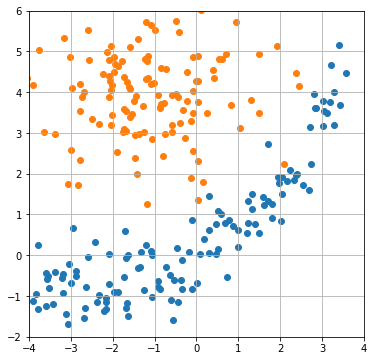

In [257]:
np.random.seed(0)
N = 125
x1 = np.linspace(-4,3.5,N).reshape(-1,1) + np.random.normal(0,0.1,N).reshape(-1,1)
y1 = np.exp(0.5*x1) - 1 + np.random.normal(0,0.6,N).reshape(-1,1)
x2 = np.random.normal(-1, 1.5, N).reshape(-1,1)
y2 = np.random.normal(4, 1, N).reshape(-1,1)

x_min = -4
x_max = 4
y_min = -2
y_max = 6

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x1,y1)
ax.scatter(x2,y2)
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.grid()

SVM classification accuracy:  0.984


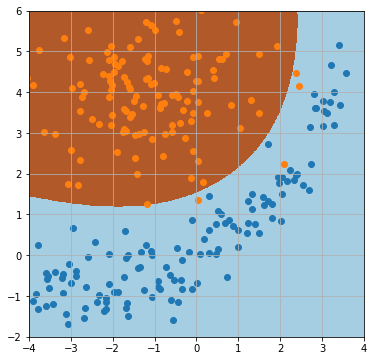

In [364]:
X = np.concatenate((np.concatenate((x1,x2)), np.concatenate((y1,y2))), axis=1)
Y = np.concatenate((np.zeros(N),np.ones(N)))

svm = SVC(gamma='scale', probability=True)
svm.fit(X,Y)
print('SVM classification accuracy: ',svm.score(X,Y))

h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(6,6))
ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
ax.scatter(x1,y1)
ax.scatter(x2,y2)
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.grid()

In [21]:
# dataframe
data_df = pd.DataFrame(X,columns=['x', 'y'])
data_df['label'] = Y

# dictionary
data_dict = {k: v for k, v in enumerate(X)}

In [92]:
def notgate(label):
    if label == 1:
        counter = 0
    elif label == 0:
        counter = 1
    return counter

def dist_face(x,y):
    return cdist(x.reshape(1,-1), y.reshape(1,-1), metric='euclidean')

def kernel(x,y):
    kernel = gaussian_kde(X.T)
    return kernel((x.reshape(1,-1), y.reshape(1,-1)))

# nearest neighbour
dist = DistanceMetric.get_metric('euclidean')
def nearest(example, label):
    data_same_label = data_df[data_df['label']==int(label)]
    distances = dist.pairwise(data_same_label[['x','y']], example)
    data_same_label.insert(3, 'distances', distances, True)
    index_min = data_same_label.distances.idxmin()
    nearest_data = np.array([data_same_label.loc[index_min]['x'], data_same_label.loc[index_min]['y']]).reshape(1,-1)
    point = data_same_label.loc[index_min].name
    return nearest_data, index_min

In [361]:
dist_threshold = 1 
density_threshold = 0.012 # 0.01 to 0.015
pred_threshold = 0.90
x_value = -3
y_value = -1

example = np.array([x_value,y_value]).reshape(1,-1)
example_label = svm.predict(example)
data_example, start_node = nearest(example, example_label)
if dist_face(example, data_example) > dist_threshold:
    print('Data point does not meet distance threshold')

In [362]:
# create weights based on distance threshold
kernel = gaussian_kde(X.T)

m, n = X.shape
w_ij = [0] * int(m*(m-1)*0.5)
edge_weights = []
k = 0
q = 0
for edge_from in range(m):
    k = 1 + edge_from
    for edge_to in range(k,m):
        if dist_face(X[edge_from], X[edge_to])[0][0] < dist_threshold:
            w_ij[q] = -np.log(kernel((X[edge_from] + X[edge_to]) /2)[0] * dist_face(X[edge_from], X[edge_to])[0][0])
        edge_weights.append((edge_from, edge_to, {'weight':w_ij[q]}))
        q += 1

nonzero_edge = []
for i in range(len(edge_weights)):
    if edge_weights[i][2]['weight'] != 0:
        nonzero_edge.append(edge_weights[i])

        
# create graph with nodes that meet density threshold
G = nx.Graph()

G.add_nodes_from(range(len(X)))
G.add_edges_from(nonzero_edge)

low_density = []
for i in range(m):
    if kernel(X[i]) < density_threshold:
        low_density.append(i)
G.remove_nodes_from(low_density)

print('nodes that meet density theshold: ', G.number_of_nodes())
print('edges that meet distance theshold: ', G.number_of_edges())

nodes that meet density theshold:  220
edges that meet distance theshold:  2294


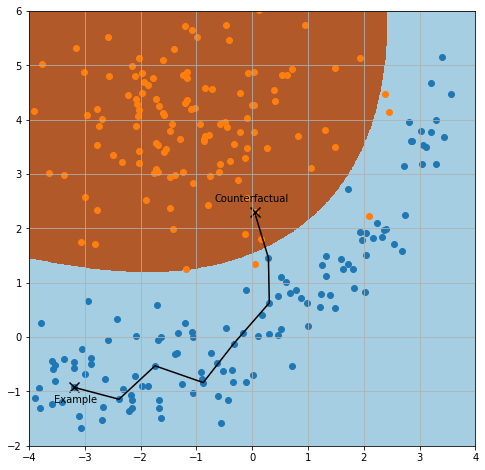

In [365]:
target_label = notgate(example_label)
target_data = data_df[data_df['label']==int(target_label)]
target_nodes = list(set(list(G.nodes())).intersection(target_data.index))

pred_threshold_fail = []
for i in target_data.index:
    index = target_data.loc[i]
    prob_target = svm.predict_proba(np.array([index['x'],index['y']]).reshape(1, -1))[0][target_label]
    if prob_target < pred_threshold:
        pred_threshold_fail.append(i)

        
length, path = nx.multi_source_dijkstra(G,target_nodes,target=start_node)
path = path[::-1]

while path[-1] in pred_threshold_fail:
    index = [i for i,node in enumerate(target_nodes) if node == path[-1]][0]
    del target_nodes[index]
          
    length, path = nx.multi_source_dijkstra(G,target_nodes,target=start_node)
    path = path[::-1]

# plot
x_path = []
y_path = []
for node in path:
    x_path.append(data_dict[node][0])
    y_path.append(data_dict[node][1])
    
fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
ax.scatter(x1,y1)
ax.scatter(x2,y2)
ax.plot(x_path,y_path, 'black')

ax.scatter(x_path[0],y_path[0], s=100, c='black', marker='x')
ax.annotate('Example', xy = (x_path[0],y_path[0]), xytext = (-20, -15), textcoords = 'offset points')
ax.scatter(x_path[-1],y_path[0-1], s=100, c='black', marker='x')
ax.annotate('Counterfactual', xy = (x_path[-1],y_path[0-1]), xytext = (-40, 10), textcoords = 'offset points')

ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.grid()